# Heterokaryon Similarity Analysis

Simple analysis which sees how close the different single cells are to MRC5/3hr/16hr/48hr samples from the heterokaryon reprogramming system. The code is similar to (borrowed from) 20200210_scProgress.

In [1]:
library(ggrepel)
library(reshape2)
require(stringr)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)
library(scales)
library(Matrix)
library(patchwork)

Loading required package: ggplot2

Loading required package: stringr

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Load

## Load Data

In [2]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20201022_n53906/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  53906 414473

In [3]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 53906     6

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5      
                    cells              
D0_AACGCGAGAAGGACCA D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC D0_ACTCGCTACTTGTGAC

In [4]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 414473      4

chr  bp1   bp2   site_name       
chr1_10268_10885 chr1 10268 10885 chr1_10268_10885
chr1_41988_42505 chr1 41988 42505 chr1_41988_42505
chr1_46058_46558 chr1 46058 46558 chr1_46058_46558
chr1_48200_48959 chr1 48200 48959 chr1_48200_48959
chr1_51306_52190 chr1 51306 52190 chr1_51306_52190
chr1_58644_59144 chr1 58644 59144 chr1_58644_59144

In [5]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [6]:
pmatRowSums = Matrix::rowSums(pmat)

### Cluster Config

In [49]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster colour  description            new_cluster
1   1      #A6D854 Pre-iPSC               14         
2   2      #F0A118 Intermediate           12         
3   3      #E85F6D Fibroblast-like         3         
4   4      #006658 Neural-like             8         
5   5      #B03743 Fibroblast              1         
6   6      #CF175A Fibroblast-like         4         
7   7      #78A824 Pre-iPSC               13         
8   8      #F4D5CD Intermediate           11         
9   9      #D4B81C Intermediate            9         
10 10      #F01D35 Fibroblast-like         5         
11 11      #7C2730 Fibroblast-like         2         
12 12      #F7A6C2 Keratinocyte-like       6         
13 13      #406614 Partially-reprogrammed 10         
14 14      #F0520A Early intermediate      7

In [50]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

## Soft Single-cell Similarity
Consider reads in all bins in heterokaryons and find similarity with raw peak counts. E.g. dot product between vector of normalized counts in 3hr - vector of normalized counts in CC. The difference vector is scaled by sgn(x).(1+|x|) and dot product is normalized by sequencing depth.

In [7]:
# het_cts <- read.table("./data/20200518_n76052/het.nodox.counts.overlap.no_iPSC.merged.500.tsv", header=T)
het_cts <- read.table("./data/20201020_n62402/het.nodox.counts.overlap.no_iPSC.merge.500.tsv", header=T)
rownames(het_cts)=paste(het_cts$chrom,het_cts$start,het_cts$end,sep='_')
het_cts$chrom = NULL
het_cts$start = NULL
het_cts$end = NULL
head(het_cts)
dim(het_cts)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10268_10885 0                      0                   
chr1_41988_42505 0                      0                   
chr1_46058_46558 2                      0                   
chr1_48200_48959 0                      0                   
chr1_51306_52190 2                      0                   
chr1_58644_59144 0                      0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10268_10885 0                     0                     
chr1_41988_42505 0                     0                     
chr1_46058_46558 0                     0                     
chr1_48200_48959 0                     0                     
chr1_51306_52190 2                     0                     
chr1_58644_59144 0                     0                     
                 het.48hr.nodox.overlap
chr1_10268_10885 2                     
chr1_41988_42505 0                     
chr1_46058_46558 0                     
chr1_48200_48959 0                     
chr1_51306_52190 2                     
chr1_58644_59144 0

[1] 414632      5

In [8]:
dim(regions)
sum(rownames(regions) %in% rownames(het_cts))

[1] 414473      4

[1] 414473

In [9]:
# rearrange to same order as regions
het_cts = het_cts[rownames(regions), ]

In [13]:
sum(rowSums(het_cts<40)==0)

[1] 62987

In [14]:
het_norm_cts = t(t(het_cts)/estimateSizeFactorsForMatrix(het_cts[rowSums(het_cts<40)==0,]))
head(het_norm_cts)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10268_10885 0.0000000              0                   
chr1_41988_42505 0.0000000              0                   
chr1_46058_46558 0.8078399              0                   
chr1_48200_48959 0.0000000              0                   
chr1_51306_52190 0.8078399              0                   
chr1_58644_59144 0.0000000              0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10268_10885 0.000000              0                     
chr1_41988_42505 0.000000              0                     
chr1_46058_46558 0.000000              0                     
chr1_48200_48959 0.000000              0                     
chr1_51306_52190 2.271407              0                     
chr1_58644_59144 0.000000              0                     
                 het.48hr.nodox.overlap
chr1_10268_10885 2.324168              
chr1_41988_42505 0.000000              
chr1_46058_46558 0.000000              
chr1_48200_48959 0.000000              
chr1_51306_52190 2.324168              
chr1_58644_59144 0.000000

In [15]:
regions_gr = GRanges(sub("_", "-", sub("_", ":",rownames(het_norm_cts))))

In [16]:
# normalize by bin size
het_binnorm_cts = 501*(het_norm_cts/width(regions_gr))
head(het_binnorm_cts)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10268_10885 0.0000000              0                   
chr1_41988_42505 0.0000000              0                   
chr1_46058_46558 0.8078399              0                   
chr1_48200_48959 0.0000000              0                   
chr1_51306_52190 0.4573195              0                   
chr1_58644_59144 0.0000000              0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10268_10885 0.000000              0                     
chr1_41988_42505 0.000000              0                     
chr1_46058_46558 0.000000              0                     
chr1_48200_48959 0.000000              0                     
chr1_51306_52190 1.285848              0                     
chr1_58644_59144 0.000000              0                     
                 het.48hr.nodox.overlap
chr1_10268_10885 1.884156              
chr1_41988_42505 0.000000              
chr1_46058_46558 0.000000              
chr1_48200_48959 0.000000              
chr1_51306_52190 1.315716              
chr1_58644_59144 0.000000

In [17]:
colMaxs(het_binnorm_cts)

[1] 1076.533 1202.273 1020.517 1256.089 1121.678

In [18]:
het_binnorm_cts_log = log2(1+het_binnorm_cts)

In [851]:
# compute delta counts from CC for 3/16/48 hr
het_CC_delta = het_binnorm_cts[, c("het.3hr.nodox.overlap","het.16hr.nodox.overlap","het.48hr.nodox.overlap")]
het_CC_delta = het_CC_delta - het_binnorm_cts[, "het.CC.nodox.overlap"]
head(het_CC_delta)

het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10268_10885 0.000000              0                     
chr1_41988_42505 0.000000              0                     
chr1_46058_46558 0.000000              0                     
chr1_48200_48959 0.000000              0                     
chr1_51306_52190 1.285848              0                     
chr1_58644_59144 0.000000              0                     
                 het.48hr.nodox.overlap
chr1_10268_10885 1.884156              
chr1_41988_42505 0.000000              
chr1_46058_46558 0.000000              
chr1_48200_48959 0.000000              
chr1_51306_52190 1.315716              
chr1_58644_59144 0.000000

In [852]:
het_CC_delta_log = sign(het_CC_delta)*log2(1+abs(het_CC_delta))
head(het_CC_delta_log)

het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10268_10885 0.000000              0                     
chr1_41988_42505 0.000000              0                     
chr1_46058_46558 0.000000              0                     
chr1_48200_48959 0.000000              0                     
chr1_51306_52190 1.192729              0                     
chr1_58644_59144 0.000000              0                     
                 het.48hr.nodox.overlap
chr1_10268_10885 1.528149              
chr1_41988_42505 0.000000              
chr1_46058_46558 0.000000              
chr1_48200_48959 0.000000              
chr1_51306_52190 1.211458              
chr1_58644_59144 0.000000

In [853]:
data.use = het_CC_delta_log

In [854]:
dot_prod = pmat %*% data.use

In [855]:
dim(dot_prod)

[1] 53906     3

In [856]:
cor(pmatRowSums, abs(dot_prod[,1])/pmatRowSums, method='spearman')

[1] -0.2629217

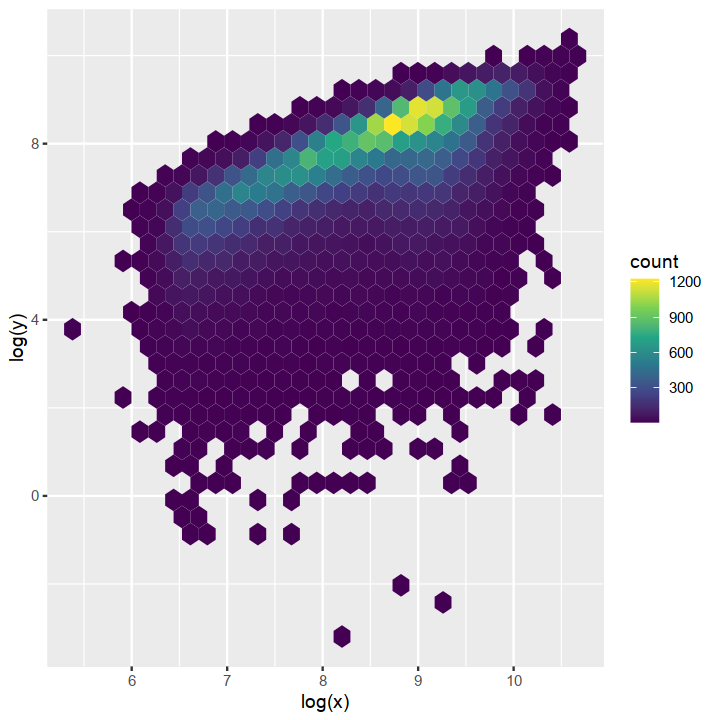

In [864]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data.frame(x=pmatRowSums, 
                  y=abs(dot_prod[,1])),
      aes(x=log(x), y=log(y))) +
scale_fill_continuous(type = "viridis") +
geom_hex() 
# geom_point() +
# coord_cartesian(xlim=c(0,quantile(pmatRowSums,0.95)))

In [858]:
quantile(dot_prod[,1]/pmatRowSums, 0.95)

95% 
0.2498803

In [859]:
plots = list()

for (i in seq(1,dim(data.use)[2])) {
    sim_score = dot_prod[,i]/pmatRowSums
    df = data.frame(metaData, n=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    plots[[i]] = ggplot(df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(limit=c(quantile(sim_score, 0.1),quantile(sim_score, 0.95)), oob = squish) +
    ggtitle(sprintf("%s (difference from Co-culture)", colnames(data.use)[i])) + 
    theme(plot.title = element_text(hjust = 0.5)) 
}

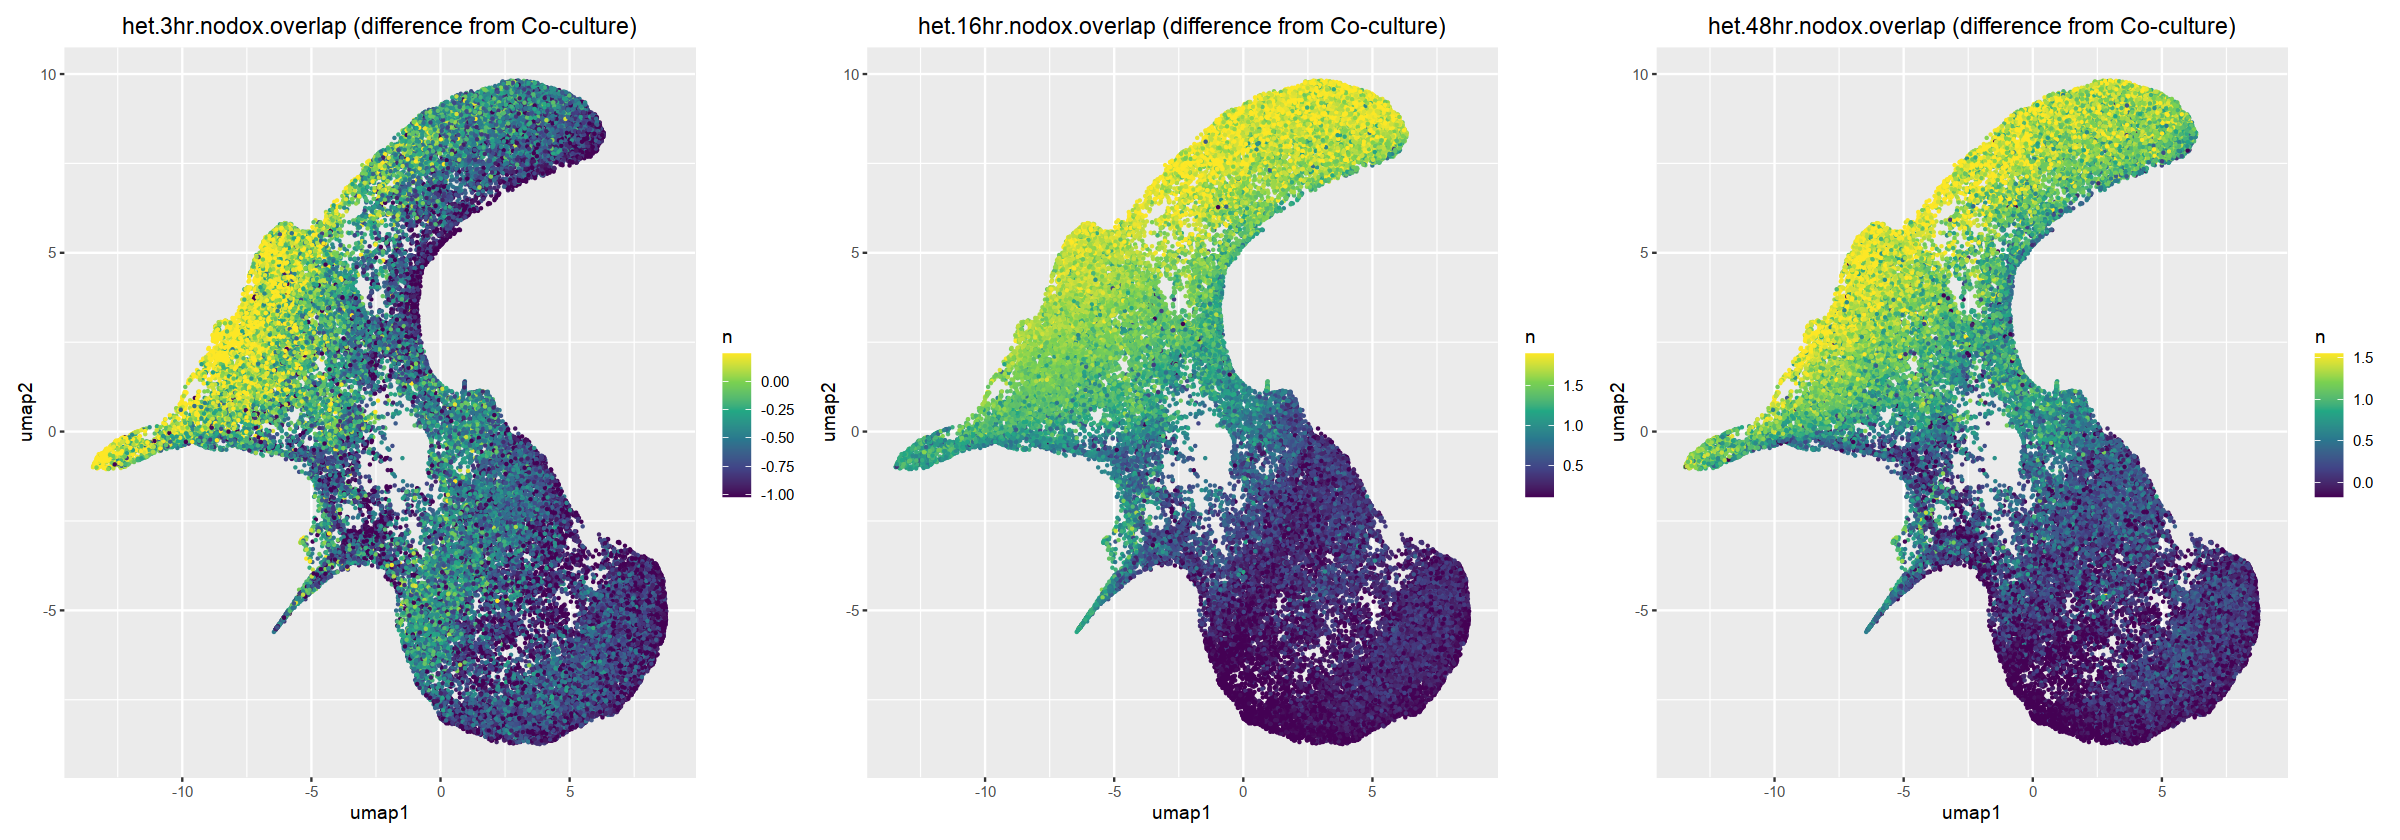

In [860]:
options(repr.plot.width = 20, repr.plot.height = 7)

wrap_plots(plots)

## Hard Single-cell similarity
Look at fraction of reads in peaks that are present in 3hr but not in CC/MRC5.

In [197]:
het_peaks <- read.table("./data/20201020_n62402/het.peaks.overlap.no_iPSC.merge.500.tsv", header=T)
rownames(het_peaks)=paste(het_peaks$chrom,het_peaks$start,het_peaks$end,sep='_')
het_peaks$chrom = NULL
het_peaks$start = NULL
het_peaks$end = NULL
head(het_peaks)
dim(het_peaks)

het.MRC5.nodox het.CC.nodox het.3hr.nodox het.16hr.nodox
chr1_10268_10885 0              0            0             0             
chr1_41988_42505 0              0            0             0             
chr1_46058_46558 0              0            0             0             
chr1_48200_48959 0              0            0             0             
chr1_51306_52190 0              0            0             0             
chr1_58644_59144 0              0            0             0             
                 het.48hr.nodox het.MRC5.dn het.CC.dn het.3hr.dn het.16hr.dn
chr1_10268_10885 0              0           0         0          0          
chr1_41988_42505 0              0           0         0          0          
chr1_46058_46558 0              0           0         0          0          
chr1_48200_48959 0              0           0         0          0          
chr1_51306_52190 0              0           0         0          0          
chr1_58644_59144 0              0           0         0          0          
                 het.48hr.dn
chr1_10268_10885 0          
chr1_41988_42505 0          
chr1_46058_46558 0          
chr1_48200_48959 0          
chr1_51306_52190 0          
chr1_58644_59144 0

[1] 414632     10

In [198]:
max(het_peaks)

[1] 15

In [199]:
# binarize, since they are peaks (construction of peak sets doesn't necessarily do that)
het_peaks[het_peaks>0] = 1
colSums(het_peaks)

het.MRC5.nodox   het.CC.nodox  het.3hr.nodox het.16hr.nodox het.48hr.nodox 
        144495         107538         118530         117947         118545 
   het.MRC5.dn      het.CC.dn     het.3hr.dn    het.16hr.dn    het.48hr.dn 
        115979          80524          95136          79444          68270

In [200]:
sum(rowSums(het_peaks)>0)

[1] 197468

In [201]:
# Peaks open in samples not open in MRC5 and CC
het_nodox_CC_MRC5_delta_peaks = het_peaks[, c("het.3hr.nodox","het.16hr.nodox","het.48hr.nodox")]
het_nodox_CC_MRC5_delta_peaks = het_nodox_CC_MRC5_delta_peaks[rowSums(het_peaks[, c("het.MRC5.nodox","het.CC.nodox")])==0, ]
dim(het_nodox_CC_MRC5_delta_peaks)

het_dn_CC_MRC5_delta_peaks = het_peaks[, c("het.3hr.dn","het.16hr.dn","het.48hr.dn")]
het_dn_CC_MRC5_delta_peaks = het_dn_CC_MRC5_delta_peaks[rowSums(het_peaks[, c("het.MRC5.dn","het.CC.dn")])==0, ]
dim(het_dn_CC_MRC5_delta_peaks)

[1] 262483      3

[1] 288208      3

In [202]:
colSums(het_nodox_CC_MRC5_delta_peaks)
colSums(het_dn_CC_MRC5_delta_peaks)

het.3hr.nodox het.16hr.nodox het.48hr.nodox 
          9921          15572          16998

het.3hr.dn het.16hr.dn het.48hr.dn 
       9508       15348       12614

In [203]:
sum(rowSums(het_nodox_CC_MRC5_delta_peaks)>0)
sum(rowSums(het_dn_CC_MRC5_delta_peaks)>0)

[1] 29644

[1] 27626

In [204]:
data.use = het_nodox_CC_MRC5_delta_peaks

In [205]:
frac_read_in_peak = list()

for (i in seq(dim(data.use)[2])) {
    frac_read_in_peak[[i]] = 100*Matrix::rowSums(pmat[,rownames(regions) %in% rownames(data.use)[data.use[,i]>0]])/pmatRowSums
}

In [206]:
cor(frac_read_in_peak[[1]], pmatRowSums,method='spearman')

[1] 0.04725901

In [211]:
hard_sim_plots = list()

for (i in seq(1,dim(data.use)[2])) {
    sim_score = frac_read_in_peak[[i]]
    df = data.frame(metaData, n=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    hard_sim_plots[[i]] = ggplot(df) +
    geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(limit=c(quantile(sim_score, 0.1),
                                  quantile(sim_score, 0.95)), 
                          oob = squish,
                         name="Normalized\nInsertions",
                          option = "B")+
    ggtitle(sprintf("%s (%d Peaks, not in MRC5/CC)", colnames(data.use)[i], sum(data.use[,i]>0))) + 
    theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()
}

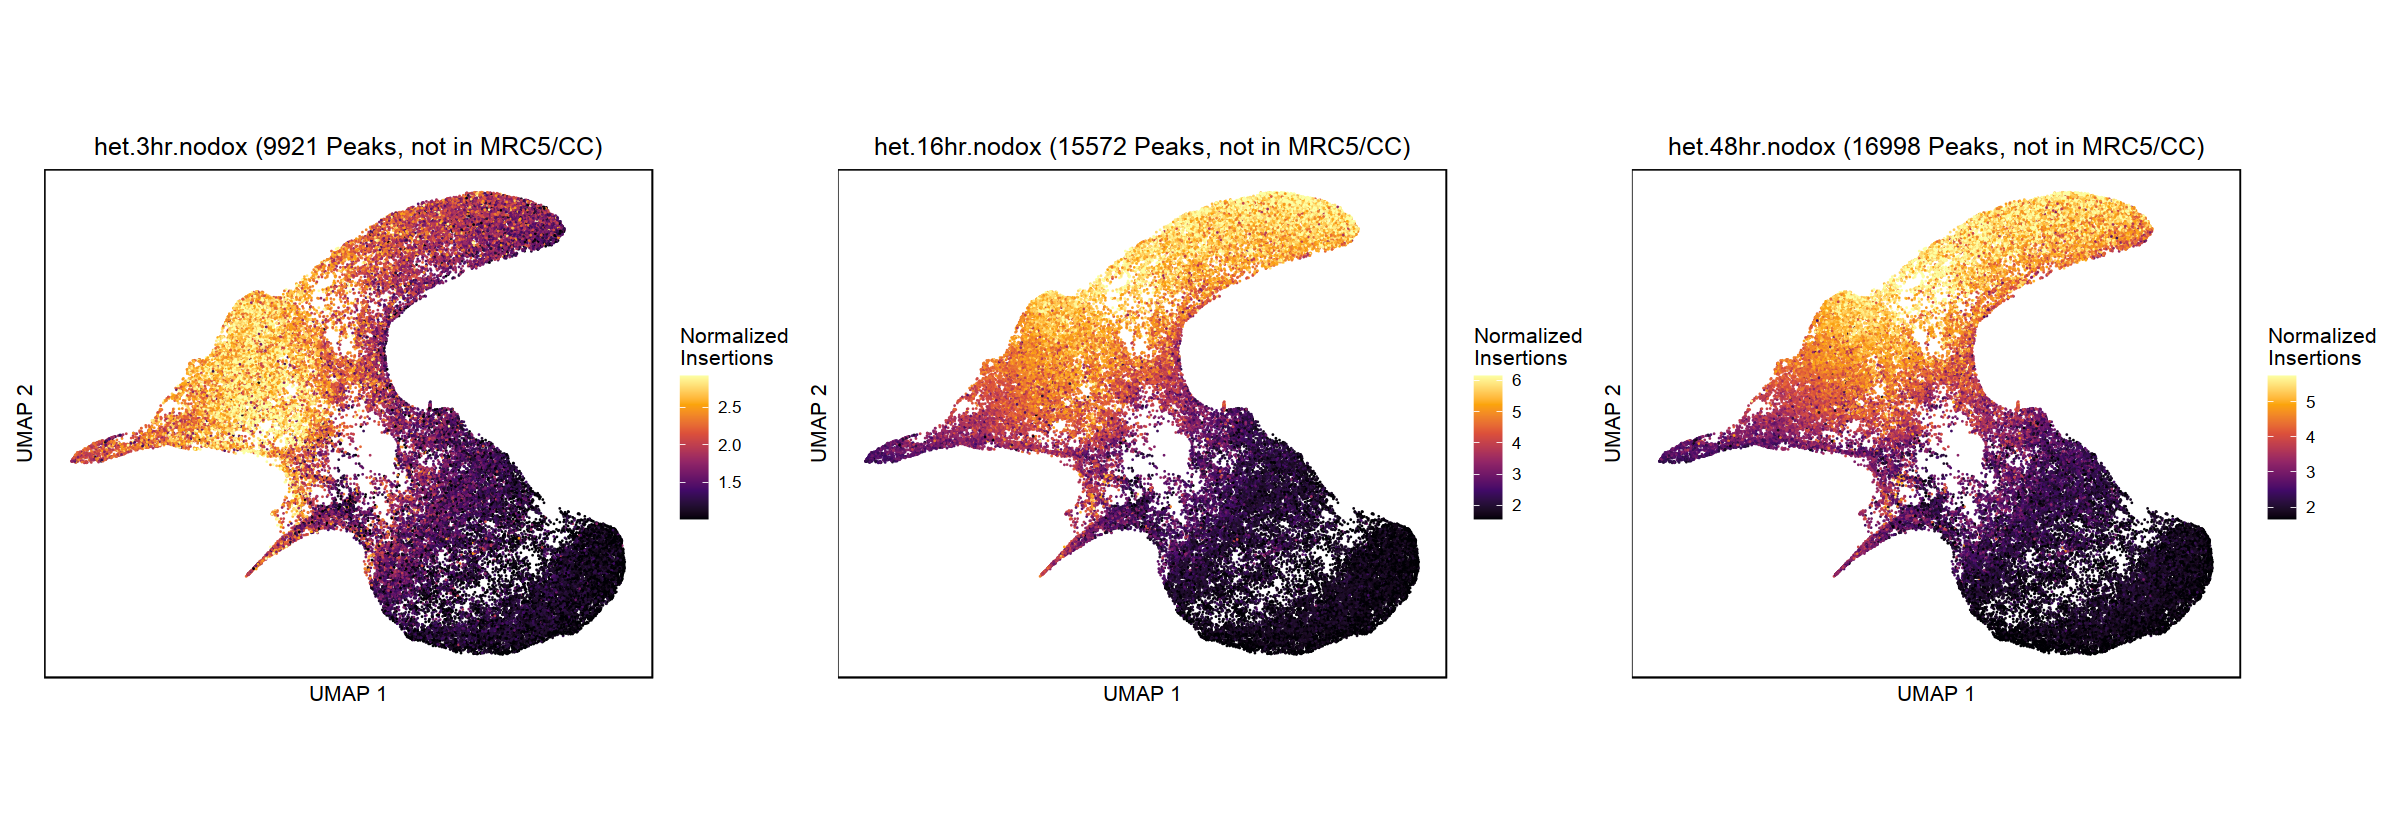

In [212]:
options(repr.plot.width = 20, repr.plot.height = 7*ceiling(dim(data.use)[2]/3))
wrap_plots(hard_sim_plots, ncol=3)

In [63]:
tmp =  rownames(data.use)[(data.use[,1]>0)]
tmp = tmp[sample(length(tmp))]
gsub("_", " ", head(tmp))

[1] "chr9 77018326 77019106"   "chr3 172278928 172279535"
[3] "chr4 110904520 110906175" "chr18 8661668 8662724"   
[5] "chr12 2921342 2922944"    "chr7 151416165 151417537"

In [64]:
conn = file("tmp")
write.table(gsub("_", "\t", tmp), file="tmp", sep="\t", quote=F, row.names=F, col.names=F)

### At Cluster Level x Peak Set

In [51]:
library(RColorBrewer)

qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

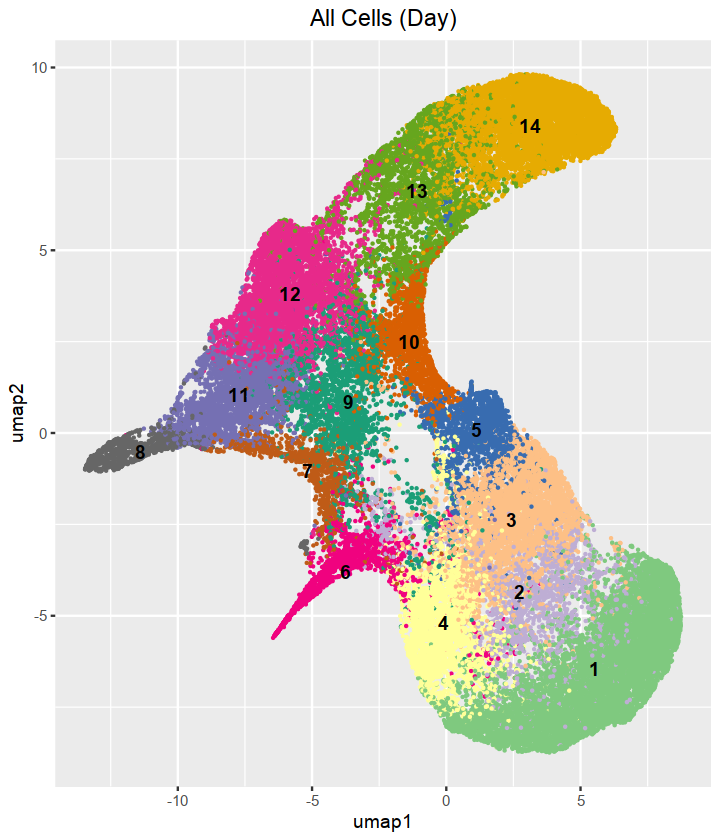

In [53]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                clst=factor(metaData$cluster_new_id))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap1","umap2")], 
                                    list(metaData$cluster_new_id), mean)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [54]:
agg_matrix = sparseMatrix(i=metaData$cluster_new_id,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(metaData$cluster_new_id)), nrow(pmat)))

In [55]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) =  rownames(regions)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1_10268_10885 72        3         21        18        8         4        
chr1_41988_42505 45        2         38        19        3         3        
chr1_46058_46558 20        1          9        10        3         2        
chr1_48200_48959 17        2          8         9        5         1        
chr1_51306_52190 25        2         12         5        3         1        
chr1_58644_59144 10        1         10         4        3         2        
                 cluster_7 cluster_8 cluster_9 cluster_10 cluster_11 cluster_12
chr1_10268_10885 5         6         14        3          12         30        
chr1_41988_42505 1         4          9        3           7         28        
chr1_46058_46558 1         1         15        9          11         35        
chr1_48200_48959 4         8         14        3          59         39        
chr1_51306_52190 0         1          2        2          12         41        
chr1_58644_59144 4         6          4        0          36         26        
                 cluster_13 cluster_14
chr1_10268_10885  8          15       
chr1_41988_42505  2           5       
chr1_46058_46558 10          18       
chr1_48200_48959  1           3       
chr1_51306_52190 35         105       
chr1_58644_59144  3           2

[1] 414473     14

In [78]:
all(rownames(norm_cts) == rownames(het_binnorm_cts_log))

[1] TRUE

In [132]:
het_and_cluster_cts = cbind(het_cts, cts)
dim(het_and_cluster_cts)

[1] 414473     19

In [179]:
# correlation between GAPDH promoter counts and esimated size factors
cor(unlist(het_and_cluster_cts["chr12_6532170_6535816", ]), 
    estimateSizeFactorsForMatrix(het_and_cluster_cts[rowSums(het_and_cluster_cts<10)==0, ]),
   method='spearman')

[1] 0.954386

In [133]:
het_and_cluster_norm_cts = t(t(het_and_cluster_cts)/estimateSizeFactorsForMatrix(het_and_cluster_cts[rowSums(het_and_cluster_cts<10)==0, ]))

In [75]:
library(rtracklayer)

peak_sets = list()
NUM_PEAK_SETS = 20

for (i in seq(NUM_PEAK_SETS)) {
    peak_sets[[i]] = import(sprintf("../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx%d.bed", i))
    start(peak_sets[[i]]) = start(peak_sets[[i]]) - 1 # adjust 
}

In [134]:
het_and_cluster_binnorm_cts = 501*(het_and_cluster_norm_cts/width(regions_gr))
het_and_cluster_binnorm_cts_log = log2(1+het_and_cluster_binnorm_cts)
head(het_and_cluster_binnorm_cts_log)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10268_10885 0.0000000              0                   
chr1_41988_42505 0.0000000              0                   
chr1_46058_46558 0.7876888              0                   
chr1_48200_48959 0.0000000              0                   
chr1_51306_52190 0.4968851              0                   
chr1_58644_59144 0.0000000              0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10268_10885 0.000000              0                     
chr1_41988_42505 0.000000              0                     
chr1_46058_46558 0.000000              0                     
chr1_48200_48959 0.000000              0                     
chr1_51306_52190 1.315816              0                     
chr1_58644_59144 0.000000              0                     
                 het.48hr.nodox.overlap cluster_1 cluster_2 cluster_3 cluster_4
chr1_10268_10885 1.377791               3.339755  2.515762  3.024175  3.208517 
chr1_41988_42505 0.000000               2.964143  2.248939  4.035960  3.508672 
chr1_46058_46558 0.000000               2.044896  1.555986  2.254614  2.733263 
chr1_48200_48959 0.000000               1.460392  1.831144  1.682707  2.121624 
chr1_51306_52190 1.081599               1.683629  1.676658  1.943795  1.378022 
chr1_58644_59144 0.000000               1.357956  1.555986  2.376064  1.704797 
                 cluster_5 cluster_6 cluster_7 cluster_8 cluster_9 cluster_10
chr1_10268_10885 3.790590  2.6669794 3.746985  3.588499  3.4225261 2.896811  
chr1_41988_42505 2.753552  2.5330628 1.987332  3.288722  3.0800658 3.119776  
chr1_46058_46558 2.794655  2.1044391 2.023482  1.708201  3.7917352 4.635793  
chr1_48200_48959 2.911635  1.0619822 3.183266  3.695799  3.1547235 2.642255  
chr1_51306_52190 2.124950  0.9517029 0.000000  1.191344  0.9780959 2.000606  
chr1_58644_59144 2.794655  2.1044391 3.729287  3.868410  2.1461550 0.000000  
                 cluster_11 cluster_12 cluster_13 cluster_14
chr1_10268_10885 2.932997   3.067824   3.200332   3.488987  
chr1_41988_42505 2.490303   3.205296   1.783782   2.341239  
chr1_46058_46558 3.088254   3.539535   3.768811   4.012515  
chr1_48200_48959 4.783180   3.138619   0.873926   1.413238  
chr1_51306_52190 2.494318   3.008622   4.701901   5.672262  
chr1_58644_59144 4.675856   3.153012   2.259807   1.423393

In [814]:
PEAK_SET_IDX = 7
peaks_select = gsub("[:-]", "_", as.character(peak_sets[[PEAK_SET_IDX]]))

In [815]:
sum(peaks_select %in% rownames(het_and_cluster_binnorm_cts_log))

[1] 16048

In [816]:
colSums(het_peaks[peaks_select, ])

het.MRC5.nodox   het.CC.nodox  het.3hr.nodox het.16hr.nodox het.48hr.nodox 
          1289            917           1592           1437           1164 
   het.MRC5.dn      het.CC.dn     het.3hr.dn    het.16hr.dn    het.48hr.dn 
           714            196            442            352            327

In [817]:
# peaks_select = peaks_select[het_peaks[peaks_select, "het.48hr.nodox"]>0]

In [818]:
100 *sum(het_and_cluster_binnorm_cts_log[peaks_select, "het.48hr.nodox.overlap"] > het_and_cluster_binnorm_cts_log[peaks_select, "het.MRC5.nodox.overlap"]+0.5)/length(peaks_select)

[1] 29.79811

In [749]:
t = colMedians(het_and_cluster_binnorm_cts[peaks_select, ])
names(t) = colnames(het_and_cluster_binnorm_cts)
t[1:5]
t[6:length(t)]

het.MRC5.nodox.overlap   het.CC.nodox.overlap  het.3hr.nodox.overlap 
              6.887115               2.123685               7.447156 
het.16hr.nodox.overlap het.48hr.nodox.overlap 
             10.622486              12.470920

cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7 
  3.150691   4.148420   5.238186   5.119054   8.878170   6.659318  11.222791 
 cluster_8  cluster_9 cluster_10 cluster_11 cluster_12 cluster_13 cluster_14 
 18.141650  19.541114  18.236751  32.410184  48.682440  49.218468  39.307839

In [302]:
SELECT_CLUSTERS = c(1,7,11,12,13,14)
selected_clusters = paste("cluster", SELECT_CLUSTERS, sep='_')

scatac_plot <- ggplot(melt(het_and_cluster_binnorm_cts_log[peaks_select ,selected_clusters]),
          aes(x=Var2,y=value)) +
    geom_violin(scale="width") +
    stat_summary(fun=median, geom="point", size=2, color="black") +
    theme(axis.text.x=element_text(angle=45, vjust=0.5))

het_plot <- ggplot(melt(het_and_cluster_binnorm_cts_log[peaks_select , 1:5]),
          aes(x=Var2,y=value)) +
    geom_violin(scale="width") +
    stat_summary(fun=median, geom="point", size=2, color="black") +
    theme(axis.text.x=element_text(angle=45, vjust=0.5))

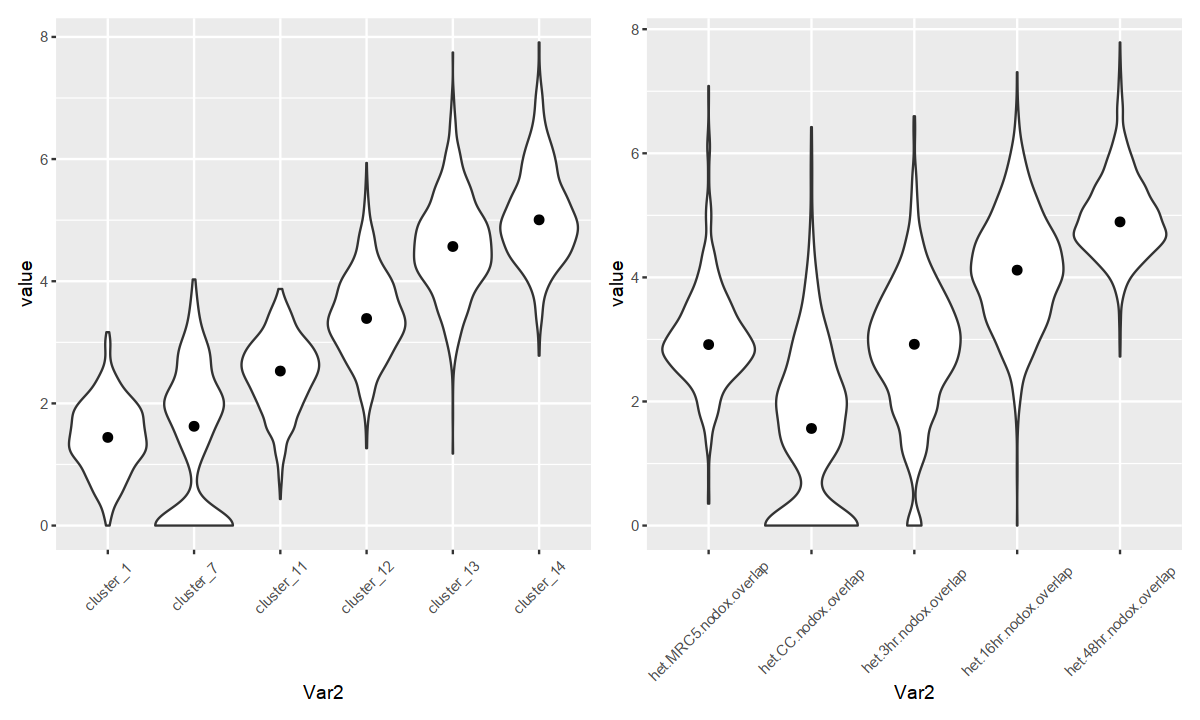

In [275]:
options(repr.plot.width = 10, repr.plot.height = 6)

scatac_plot | het_plot

### At Fine Cluster Level

In [46]:
# load fine clusters from file
fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/fine_clusters.tsv", 
            header = T)
all(fine_clusters$sample_barcode==rownames(metaData))

clusters = fine_clusters$clusters
head(fine_clusters)

[1] TRUE

sample_barcode      clusters
1 D0_AAACAACGACGATTAC 26      
2 D0_AAACAACGAGCGCACT 42      
3 D0_AAACACGCTACGCCAC 42      
4 D0_AAACACGCTAGTACGG 11      
5 D0_AAACACGCTCCTCAAA 13      
6 D0_AAACACGCTCGAGTGA 10

In [47]:
library(RColorBrewer)

qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

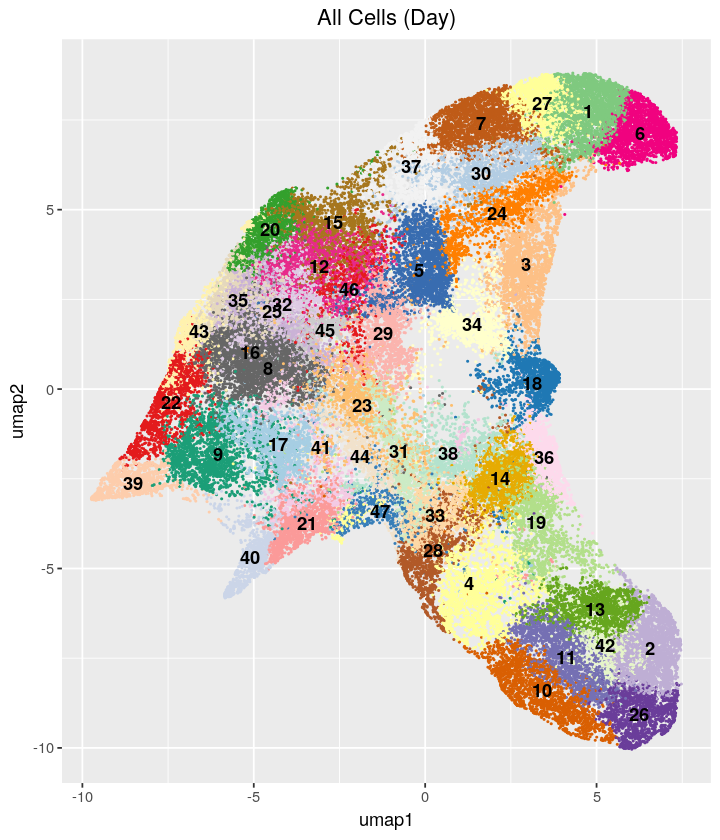

In [48]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap1","umap2")], 
                                    list(clusters), mean)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [49]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(pmat)))

In [31]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) =  rownames(regions)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1_10355_10867  7        18        10        1          7         4       
chr1_41995_42521  1        12         6        6          6         3       
chr1_46067_46593  5         4        15        5         15         4       
chr1_48475_48975  0         2         3        1          4         1       
chr1_51286_52235 30         6        46        3          6        35       
chr1_58648_59148  0         2         4        2          0         2       
                 cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_38
chr1_10355_10867  3        10        10        15         ⋯ 10        
chr1_41995_42521  0         8        23         6         ⋯  5        
chr1_46067_46593  8        17        10         5         ⋯  6        
chr1_48475_48975  2        31        10         2         ⋯  3        
chr1_51286_52235 43        12         1         6         ⋯  3        
chr1_58648_59148  1        23        10         1         ⋯  4        
                 cluster_39 cluster_40 cluster_41 cluster_42 cluster_43
chr1_10355_10867 4          4          5          2           3        
chr1_41995_42521 4          3          6          3           1        
chr1_46067_46593 1          3          6          1           3        
chr1_48475_48975 5          1          5          2          12        
chr1_51286_52235 1          1          1          1           5        
chr1_58648_59148 3          2          3          1           9        
                 cluster_44 cluster_45 cluster_46 cluster_47
chr1_10355_10867 2           8         3          5         
chr1_41995_42521 9           7         4          1         
chr1_46067_46593 9          11         6          2         
chr1_48475_48975 2           2         2          2         
chr1_51286_52235 2          11         2          0         
chr1_58648_59148 0           4         2          1

[1] 409052     47

In [32]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<10)==0, ]))

In [61]:
hard_sim_plots = list()

for (i in seq(1,dim(data.use)[2])) {
    sim_score = log2(colSums(norm_cts[rownames(regions) %in% rownames(data.use)[data.use[,i]>0], ]))[clusters]
    df = data.frame(metaData, n=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    hard_sim_plots[[i]] = ggplot(df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(# limit=c(min(sim_score),
                          #       max(sim_score)), 
                          # oob = squish,
                         name="Log2\nNormalized Counts") +
    ggtitle(sprintf("%s (%d Peaks, not in MRC5/CC)", colnames(data.use)[i], sum(data.use[,i]>0))) + 
    theme(plot.title = element_text(hjust = 0.5)) 
}

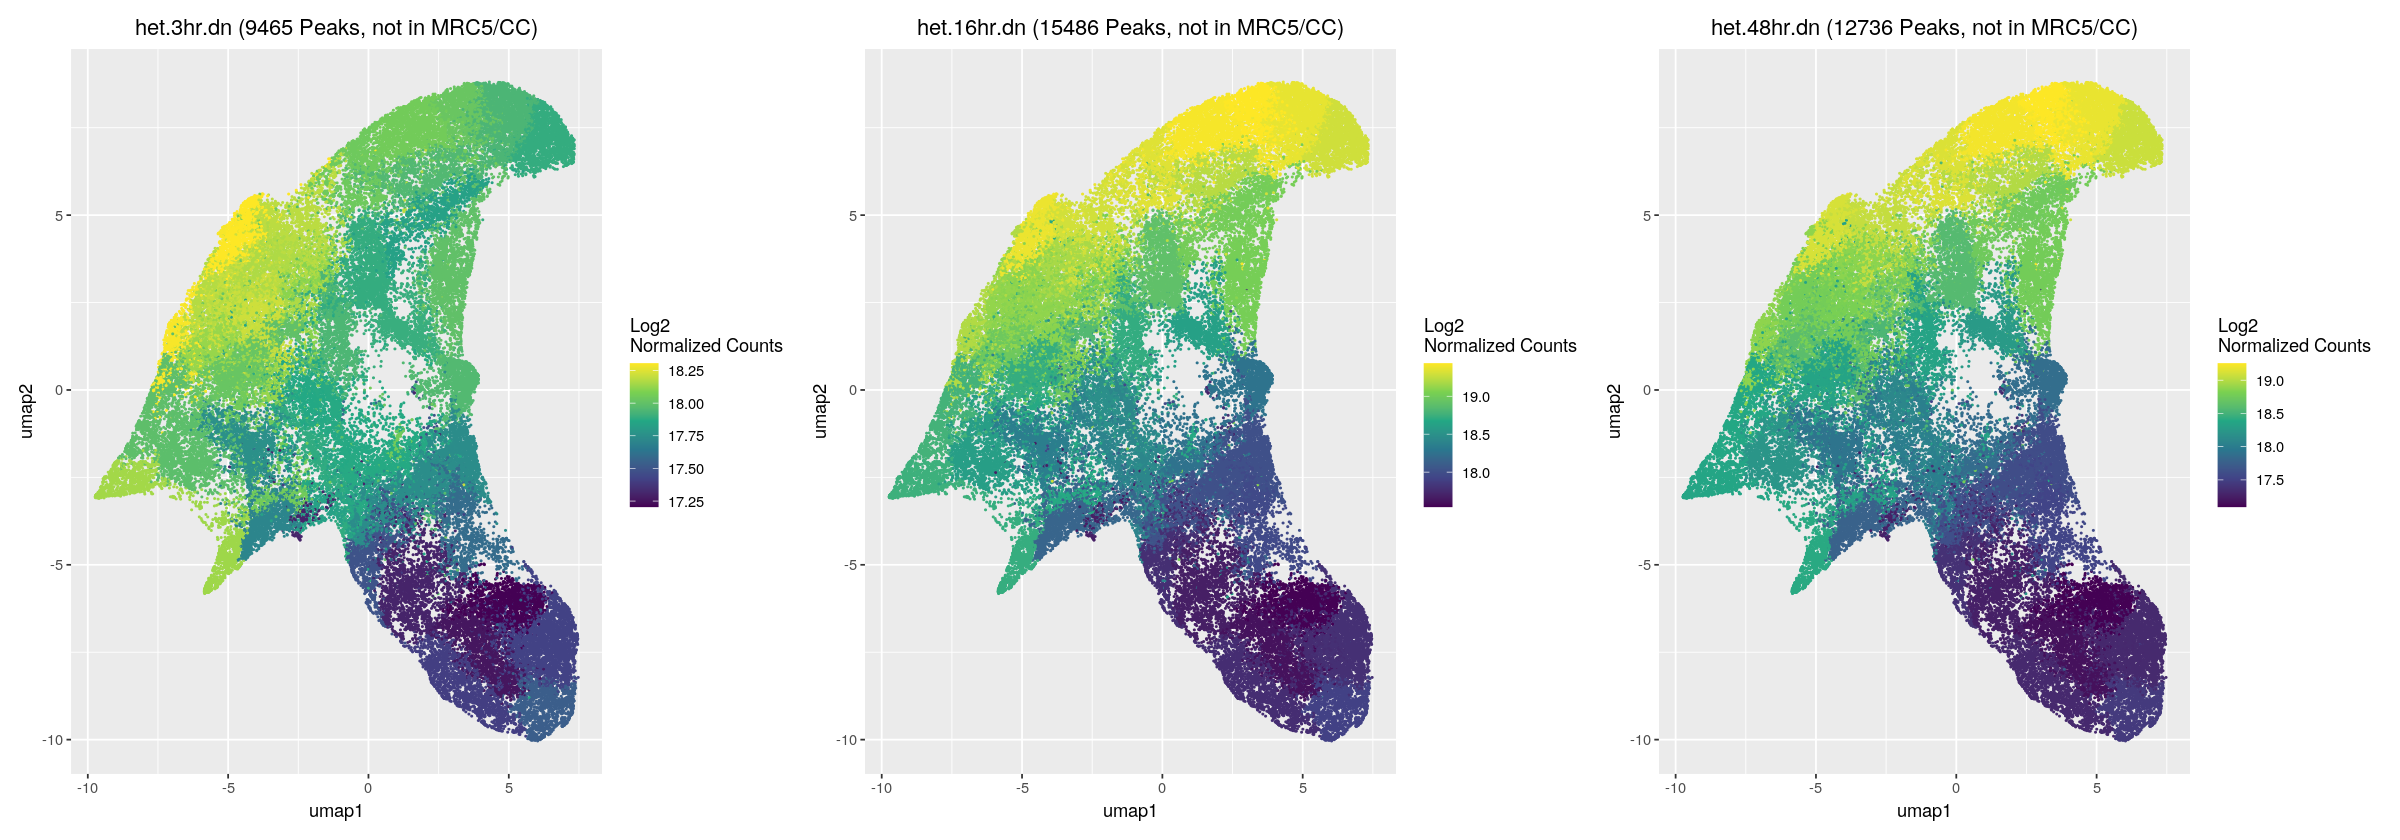

In [62]:
options(repr.plot.width = 20, repr.plot.height = 7)
wrap_plots(hard_sim_plots, ncol=3)